In [1]:
import numpy as np
import scipy.stats
import pandas as pd
from os.path import join
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

from src.utilities.utils import get_files

In [2]:
SMALL_SIZE  = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 40

plt.rc('font', size        = BIGGER_SIZE)   # controls default text sizes
plt.rc('axes', titlesize   = BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize   = BIGGER_SIZE)   # fontsize of the x and y labels
plt.rc('xtick', labelsize  = MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize  = MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize  = SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize = BIGGER_SIZE)   # fontsize of the figure title

In [3]:
def get_acc_values(cpaths, clfs, op_values, index):

    accuracies = {k: None for k in clfs}

    for cl, path in zip(clfs, cpaths):
        ops = {k: None for k in op_values}

        for D, tau in op_values:
            metrics = "METRICS_[{}, {}].csv".format(D, tau)

            data = pd.read_csv(join(path, metrics))

            ### mean accuracy        
            ops[(D, tau)] = float(data["general.10"][1])

        accuracies[cl] = ops

    df_final       = pd.DataFrame(accuracies) * 100
    df_final.index = index
        
    return df_final

## D values

In [4]:
def plot_data_D(df, ticks, title, save_title):
    
    ax = df.plot(figsize = (19, 10), style = 'o-', legend = False)

    ax.set_xlabel("D values", fontsize = 20)
    plt.xticks(ticks)

    ax.set_ylabel("Accuracy (%)", fontsize = 20)
    plt.ylim((43, 80))
    
    ax.set_title(title, fontsize = 20)

    ax.grid(True, color = "lightgray", linestyle='-')
    
    ax.legend(frameon = True, ncol = 6)

    plt.tight_layout()

    plt.savefig('figs/' + save_title + '.pdf')

In [34]:
paths      = join("db", "GeoLife")
clf_paths  = get_files(paths, "classification", rec = True)

clfs       = ["k-NN", "SVM-R", "SVM-L", "DT", "RF", "XGBoost"]
op_values  = [(3, 1), (4, 1), (5, 1), (6, 1)]
index      = [3, 4, 5, 6]

In [35]:
df_pe       = get_acc_values(clf_paths[0:6], clfs, op_values, index)
df_sc       = get_acc_values(clf_paths[6:12], clfs, op_values, index)
df_st       = get_acc_values(clf_paths[12:18], clfs, op_values, index)
df_pe_sc    = get_acc_values(clf_paths[18:24], clfs, op_values, index)
df_pe_sc_st = get_acc_values(clf_paths[24:30], clfs, op_values, index)

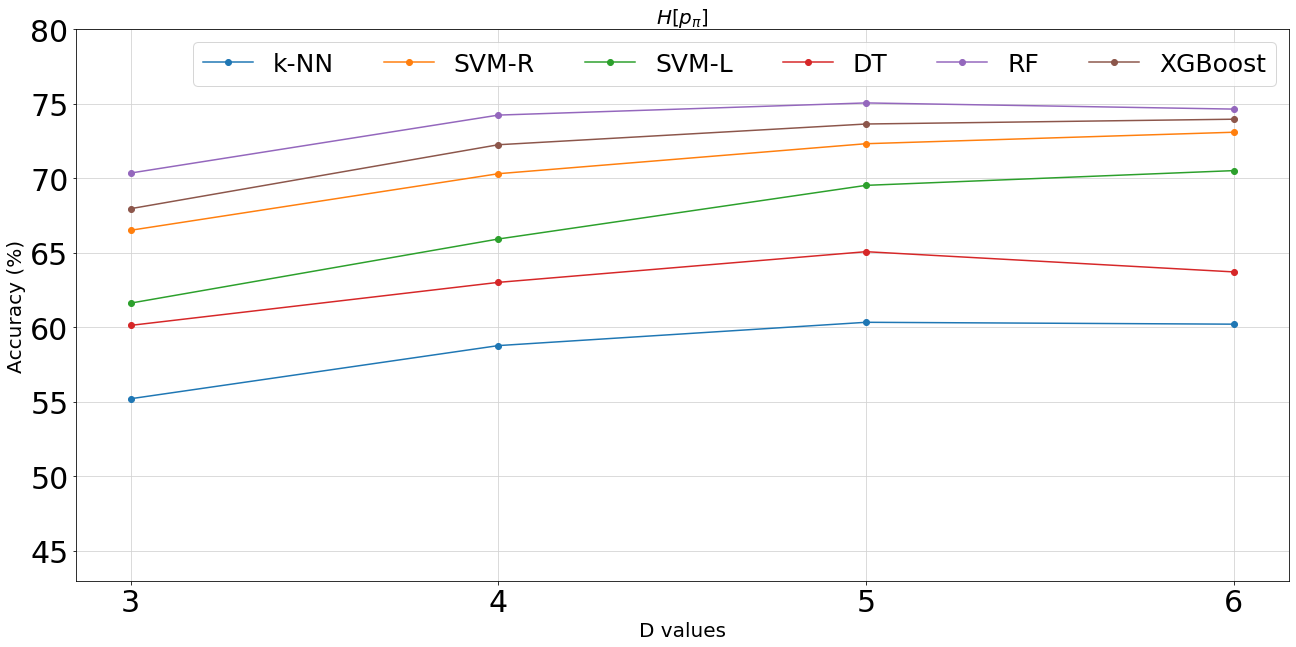

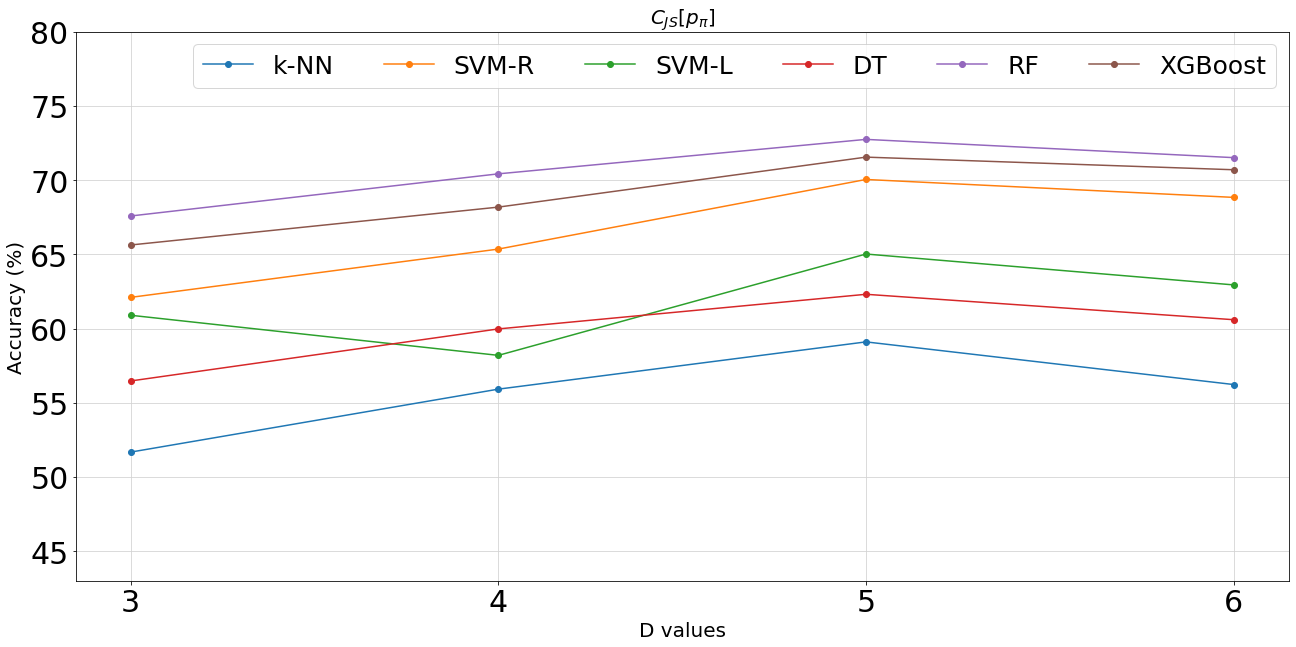

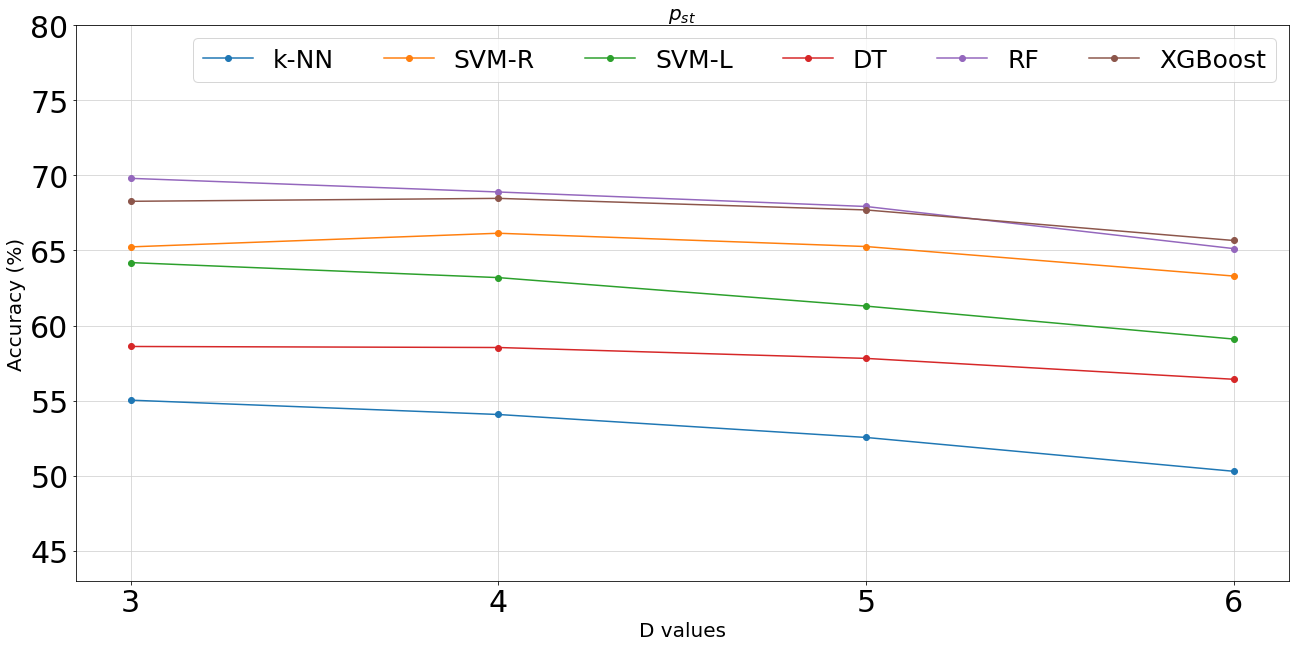

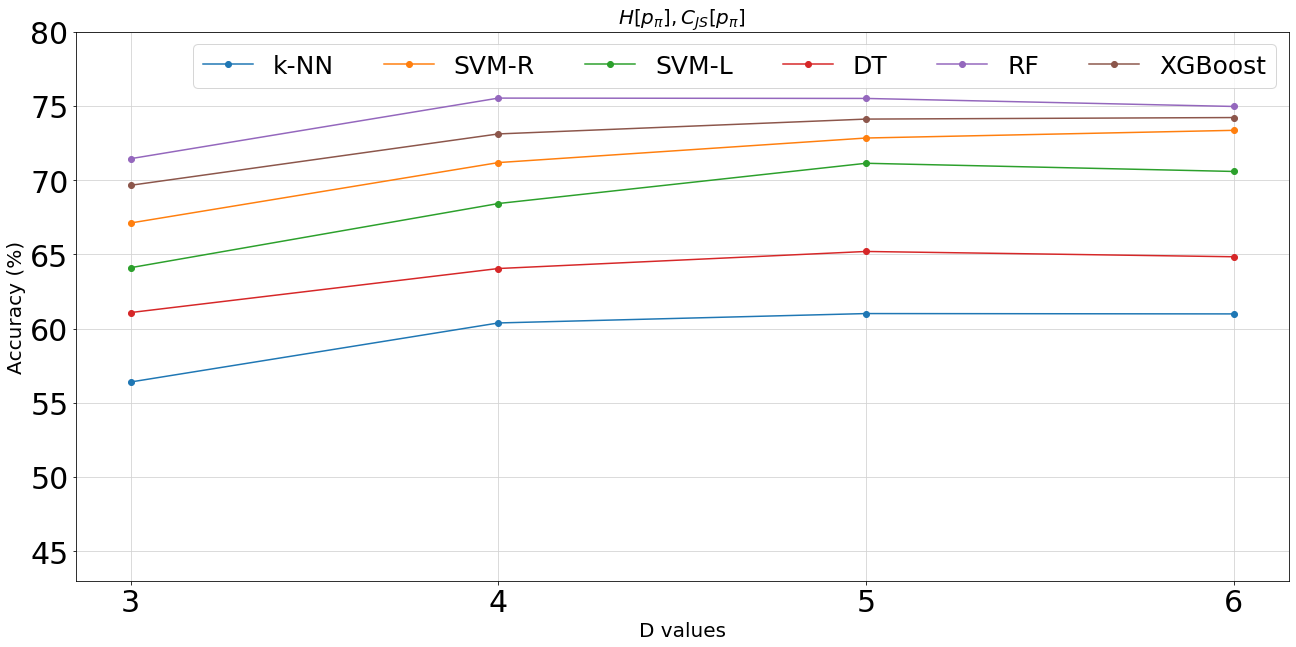

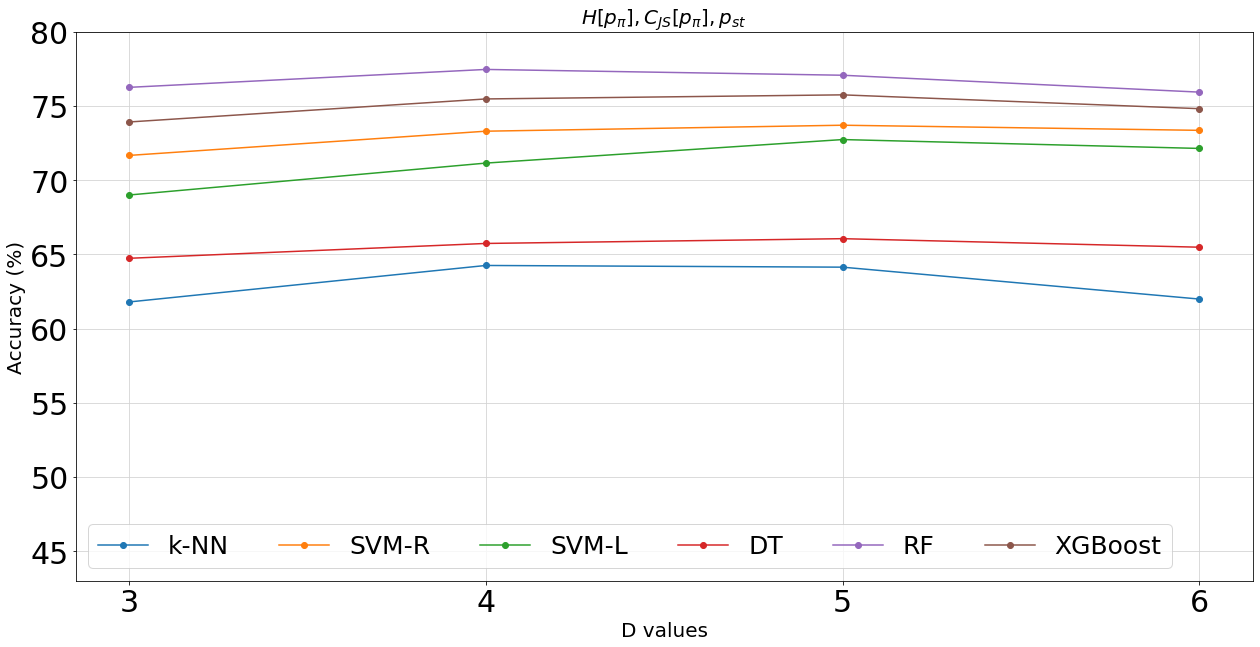

In [36]:
ax1 = plot_data_D(df_pe, index, r'$H[p_\pi]$', "[D_t1]_perm")
ax2 = plot_data_D(df_sc, index, r'$C_{JS}[p_\pi]$', "[D_t1]_comp")
ax3 = plot_data_D(df_st, index, r'$p_{st}$', "[D_t1]_self_prob")
ax4 = plot_data_D(df_pe_sc, index, r'$H[p_\pi], C_{JS}[p_\pi]$', "[D_t1]_perm_comp")
ax5 = plot_data_D(df_pe_sc_st, index, r'$H[p_\pi], C_{JS}[p_\pi], p_{st}$', "[D_t1]_perm_comp_self")

## $\tau$ values

In [8]:
def plot_data_tau(df, ticks, title, save_title):
    
    ax = df.plot(figsize = (19, 10), style = 'o-', legend = False)

    ax.set_xlabel(r"$\tau$ values", fontsize = 20)
    plt.xticks(ticks)

    ax.set_ylabel("Accuracy (%)", fontsize = 20)
    plt.ylim((33, 80))
    
    ax.set_title(title, fontsize = 20)

    ax.grid(True, color = "lightgray", linestyle='-')
    
    ax.legend(frameon = True, ncol = 6)

    plt.tight_layout()

    plt.savefig('figs/' + save_title + '.pdf')

In [9]:
paths      = join("db", "GeoLife")
clf_paths  = get_files(paths, "classification", rec = True)

clfs       = ["k-NN", "SVM-R", "SVM-L", "DT", "RF", "XGBoost"]

op_values  = [(4, 1), (4, 5), (4, 10), (4, 15)]

index      = [1, 5, 10, 15]

In [10]:
df_pe       = get_acc_values(clf_paths[30:36], clfs, op_values, index)
df_sc       = get_acc_values(clf_paths[36:42], clfs, op_values, index)
df_st       = get_acc_values(clf_paths[42:48], clfs, op_values, index)
df_pe_sc    = get_acc_values(clf_paths[48:54], clfs, op_values, index)
df_pe_sc_st = get_acc_values(clf_paths[54:60], clfs, op_values, index)

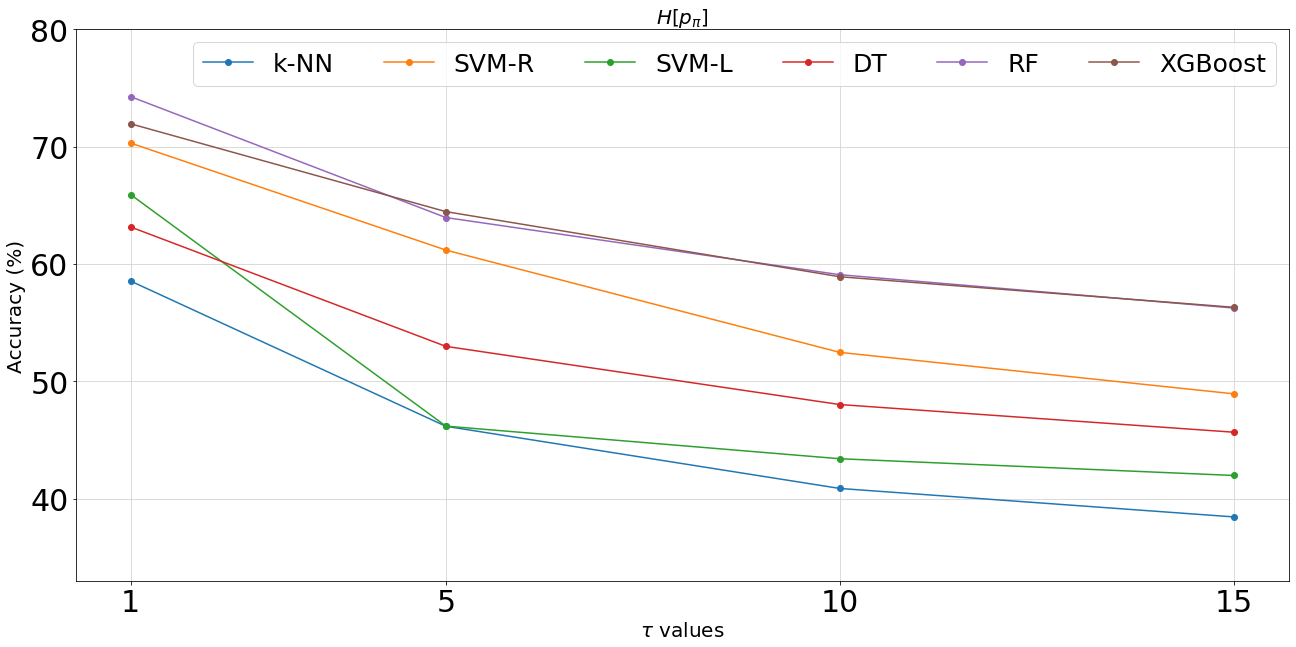

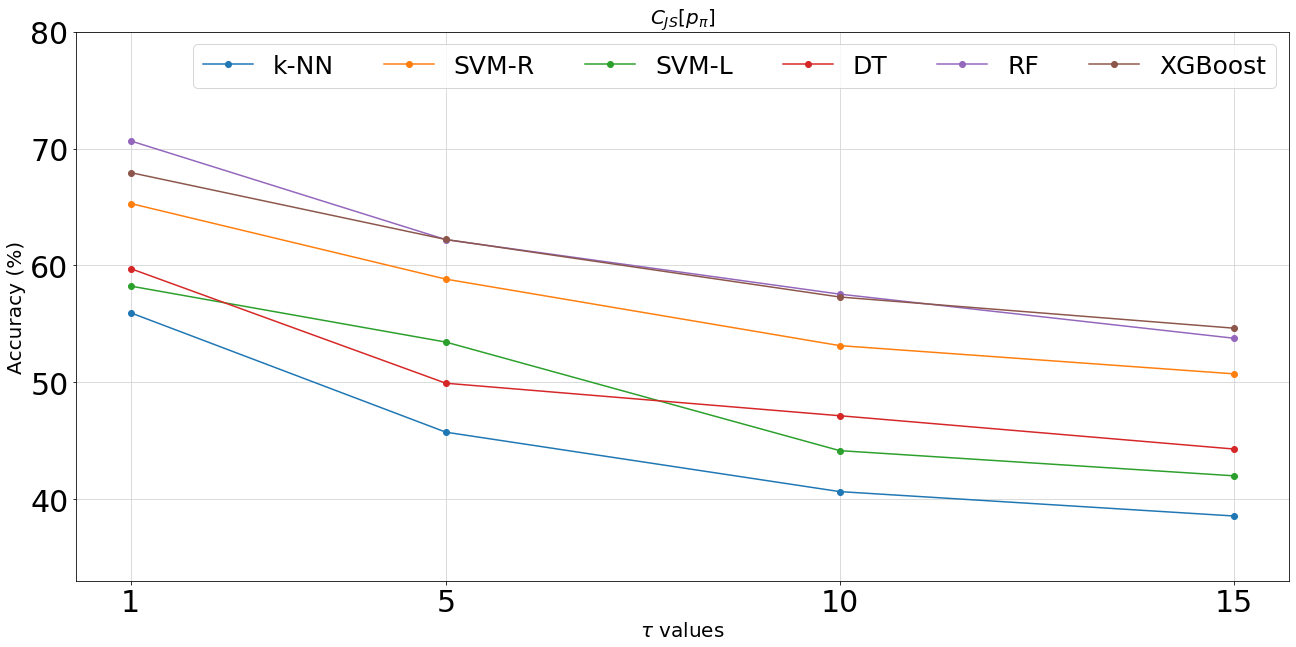

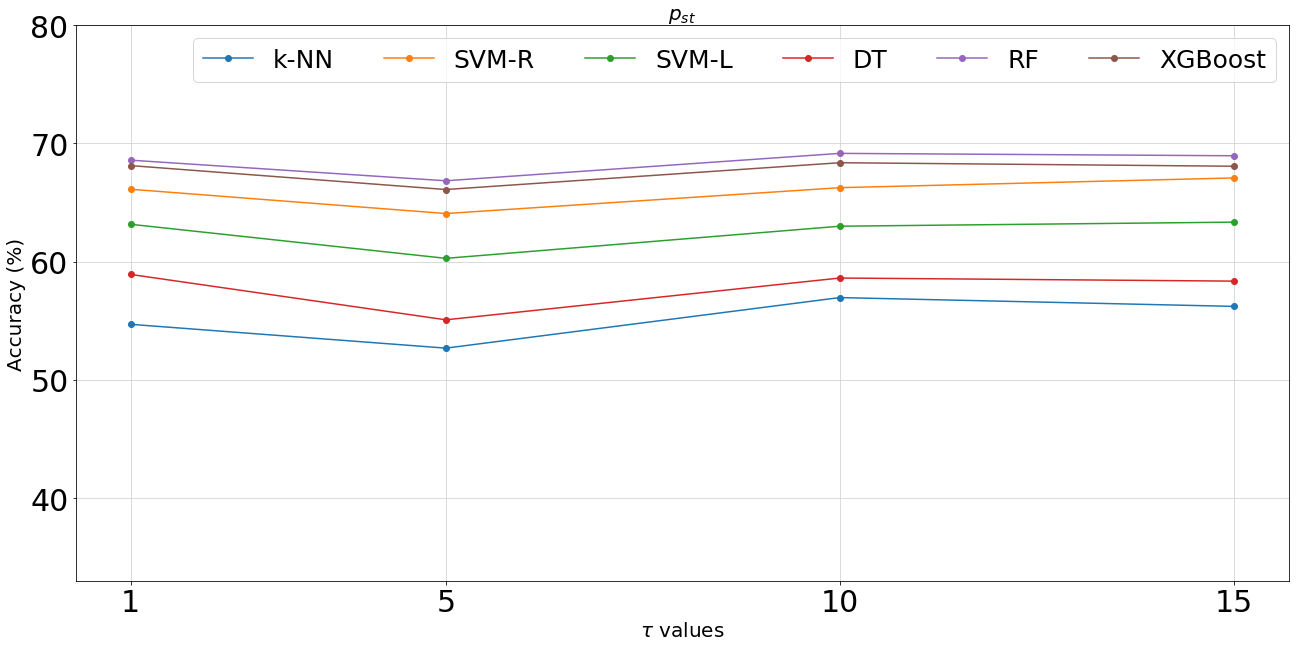

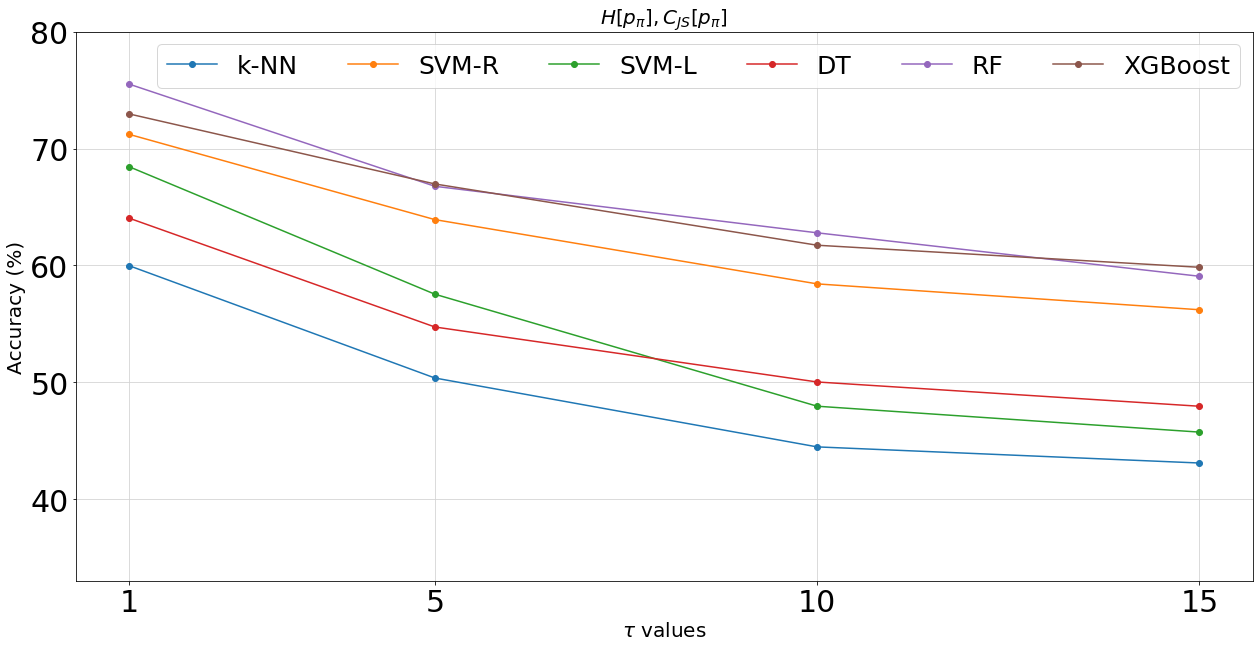

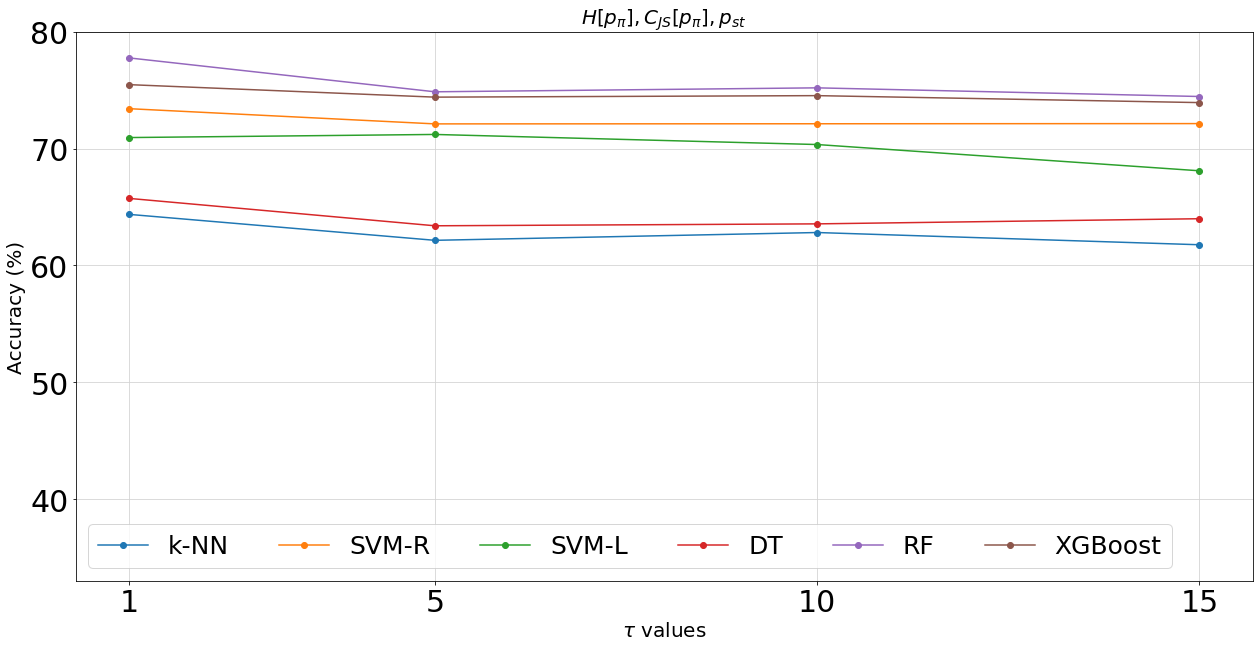

In [11]:
ax1 = plot_data_tau(df_pe, index, r'$H[p_\pi]$', "[D4_t]_perm")
ax2 = plot_data_tau(df_sc, index, r'$C_{JS}[p_\pi]$', "[D4_t]_comp")
ax3 = plot_data_tau(df_st, index, r'$p_{st}$', "[D4_t]_self_prob")
ax4 = plot_data_tau(df_pe_sc, index, r'$H[p_\pi], C_{JS}[p_\pi]$', "[D4_t]_perm_comp")
ax5 = plot_data_tau(df_pe_sc_st, index, r'$H[p_\pi], C_{JS}[p_\pi], p_{st}$', "[D4_t]_perm_comp_self")

## Classification results

In [8]:
def mean_confidence_interval(data, confidence = 0.95):
    a     = 1.0 * np.array(data)
    n     = len(a)
    
    m, se = np.mean(a), scipy.stats.sem(a)
    h     = se * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
    return m, h


def get_statistics(data, classes, kind, n_folds, metric):
    
    dstats = {k: [] for k in classes}
    cint   = {k: [] for k in classes}

    for v in range(n_folds):
        if v == 0:
            values = "{}".format(kind)
        else:
            values = "{}.{}".format(kind, v)
            
        stat = [x for x in data[values][metric].replace("[", '').replace("]", '').split(" ") if len(x) > 0]
        stat = list(map(float, stat))
        
        if kind == "perclass":
            if metric != 1:
                for enum, c in enumerate(classes):
                    dstats[c].append(stat[enum] * 100)

            else:
                enum = 0
                for c in classes:
                    dstats[c].append(stat[enum] * 100)
                    
        else:
            enum = 0
            for c in classes:
                dstats[c].append(stat[enum] * 100)
            
    for s in classes:
        cint[s] = mean_confidence_interval(dstats[s], confidence = 0.95)
            
    return dstats, cint

In [9]:
def print_values(folder, classes, n_folds, kind, D, baseline = False):
    if baseline == True:
        data    = pd.read_csv(folder)
        
    else:
        path    = join("db", "GeoLife", folder, f"METRICS_[{D}, 1].csv")
        data    = pd.read_csv(path)
    
    dacc, cacc = get_statistics(data, classes, kind, n_folds, 1)
    df1, cf1   = get_statistics(data, classes, kind, n_folds, 2)
    drec, crec = get_statistics(data, classes, kind, n_folds, 3)
    dpre, cpre = get_statistics(data, classes, kind, n_folds, 4)

    print("Accuracy: {:.4} (+- {:.2})".format(cacc[classes[0]][0], cacc[classes[0]][1]))

    for c in classes:
        string = "\n--- {} ---\n F1 : {:.4} (+- {:.2})\n REC: {:.4} (+- {:.2})\n PRE: {:.4} (+- {:.2})\n"
        print(string.format(c, cf1[c][0], cf1[c][1], crec[c][0], crec[c][1], cpre[c][0], cpre[c][1]))
        
    return dacc, cacc, df1, cf1, drec, crec, dpre, cpre

In [6]:
## metric: 2 F1, 3 recall, 4 precision
kind    = "general"
n_folds = 10

In [32]:
paths      = join("db", "GeoLife")
base_paths = get_files(paths, "baseline*.csv", rec = False)

In [45]:
print_values(base_paths[5], classes, n_folds, kind, D, baseline = True)

Accuracy: 87.22 (+- 0.8)

--- bike ---
 F1 : 84.96 (+- 0.99)
 REC: 84.49 (+- 1.0)
 PRE: 85.56 (+- 1.0)


--- bus ---
 F1 : 84.96 (+- 0.99)
 REC: 84.49 (+- 1.0)
 PRE: 85.56 (+- 1.0)


--- driving ---
 F1 : 84.96 (+- 0.99)
 REC: 84.49 (+- 1.0)
 PRE: 85.56 (+- 1.0)


--- walk ---
 F1 : 84.96 (+- 0.99)
 REC: 84.49 (+- 1.0)
 PRE: 85.56 (+- 1.0)



In [5]:
paths     = join("db", "GeoLife")
clf_paths = get_files(paths, "classification", rec = True)

In [20]:
D       = 4
folder  = clf_paths[65].split("/")[-1]
classes = ["bike", "bus", "driving", "walk"]

dacc, cacc, df1, cf1, drec, crec, dpre, cpre = print_values(folder, classes, n_folds, kind, D)

Accuracy: 90.03 (+- 0.64)

--- bike ---
 F1 : 88.28 (+- 0.81)
 REC: 87.6 (+- 0.84)
 PRE: 89.1 (+- 0.79)


--- bus ---
 F1 : 88.28 (+- 0.81)
 REC: 87.6 (+- 0.84)
 PRE: 89.1 (+- 0.79)


--- driving ---
 F1 : 88.28 (+- 0.81)
 REC: 87.6 (+- 0.84)
 PRE: 89.1 (+- 0.79)


--- walk ---
 F1 : 88.28 (+- 0.81)
 REC: 87.6 (+- 0.84)
 PRE: 89.1 (+- 0.79)



In [6]:
## metric: 2 F1, 3 recall, 4 precision
kind    = "perclass"
n_folds = 10

In [10]:
D       = 4
folder  = clf_paths[65].split("/")[-1]
classes = ["bike", "bus", "driving", "walk"]

dacc, cacc, df1, cf1, drec, crec, dpre, cpre = print_values(folder, classes, n_folds, kind, D)

Accuracy: 90.03 (+- 0.64)

--- bike ---
 F1 : 90.4 (+- 1.2)
 REC: 87.13 (+- 2.1)
 PRE: 94.0 (+- 1.1)


--- bus ---
 F1 : 83.67 (+- 1.5)
 REC: 83.73 (+- 1.5)
 PRE: 83.67 (+- 2.1)


--- driving ---
 F1 : 84.33 (+- 1.9)
 REC: 82.91 (+- 2.8)
 PRE: 85.86 (+- 1.3)


--- walk ---
 F1 : 94.73 (+- 0.49)
 REC: 96.65 (+- 0.71)
 PRE: 92.89 (+- 0.92)



In [11]:
df_pre = pd.DataFrame.from_dict(dpre)
df_f1  = pd.DataFrame.from_dict(df1)
df_rec = pd.DataFrame.from_dict(drec)

In [12]:
df = pd.concat([df_pre['bike'], df_pre['bus'], df_pre['walk'], df_pre['driving']])
df = df.reset_index(drop = True)

df2 = pd.concat([df_f1['bike'], df_f1['bus'], df_f1['walk'], df_f1['driving']])
df2 = df2.reset_index(drop = True)

df3 = pd.concat([df_rec['bike'], df_rec['bus'], df_rec['walk'], df_rec['driving']])
df3 = df3.reset_index(drop = True)

In [13]:
index = ['bike'] * 10 + ['bus'] * 10 + ['walk'] * 10 + ['driving'] * 10

In [14]:
df = pd.concat([df, df2, df3, pd.Series(index)], axis = 1)

In [15]:
df.columns = ['Precision', 'F1', 'Sensitivity', 'Classes']

df

,Precision,F1,Sensitivity,Classes
0,94.520548,90.491803,86.792453,bike
1,95.652174,88.888889,83.018868,bike
2,92.452830,92.452830,92.452830,bike
3,95.862069,91.447368,87.421384,bike
4,95.270270,91.856678,88.679245,bike
5,92.907801,87.333333,82.389937,bike
6,92.617450,89.320388,86.250000,bike
7,95.364238,92.604502,90.000000,bike
8,92.000000,89.032258,86.250000,bike
9,93.333333,90.614887,88.050314,bike


In [18]:
#### standard deviation of buses
df[12:20].std()

Precision      2.614334
F1             1.640804
Sensitivity    1.428808
dtype: float64

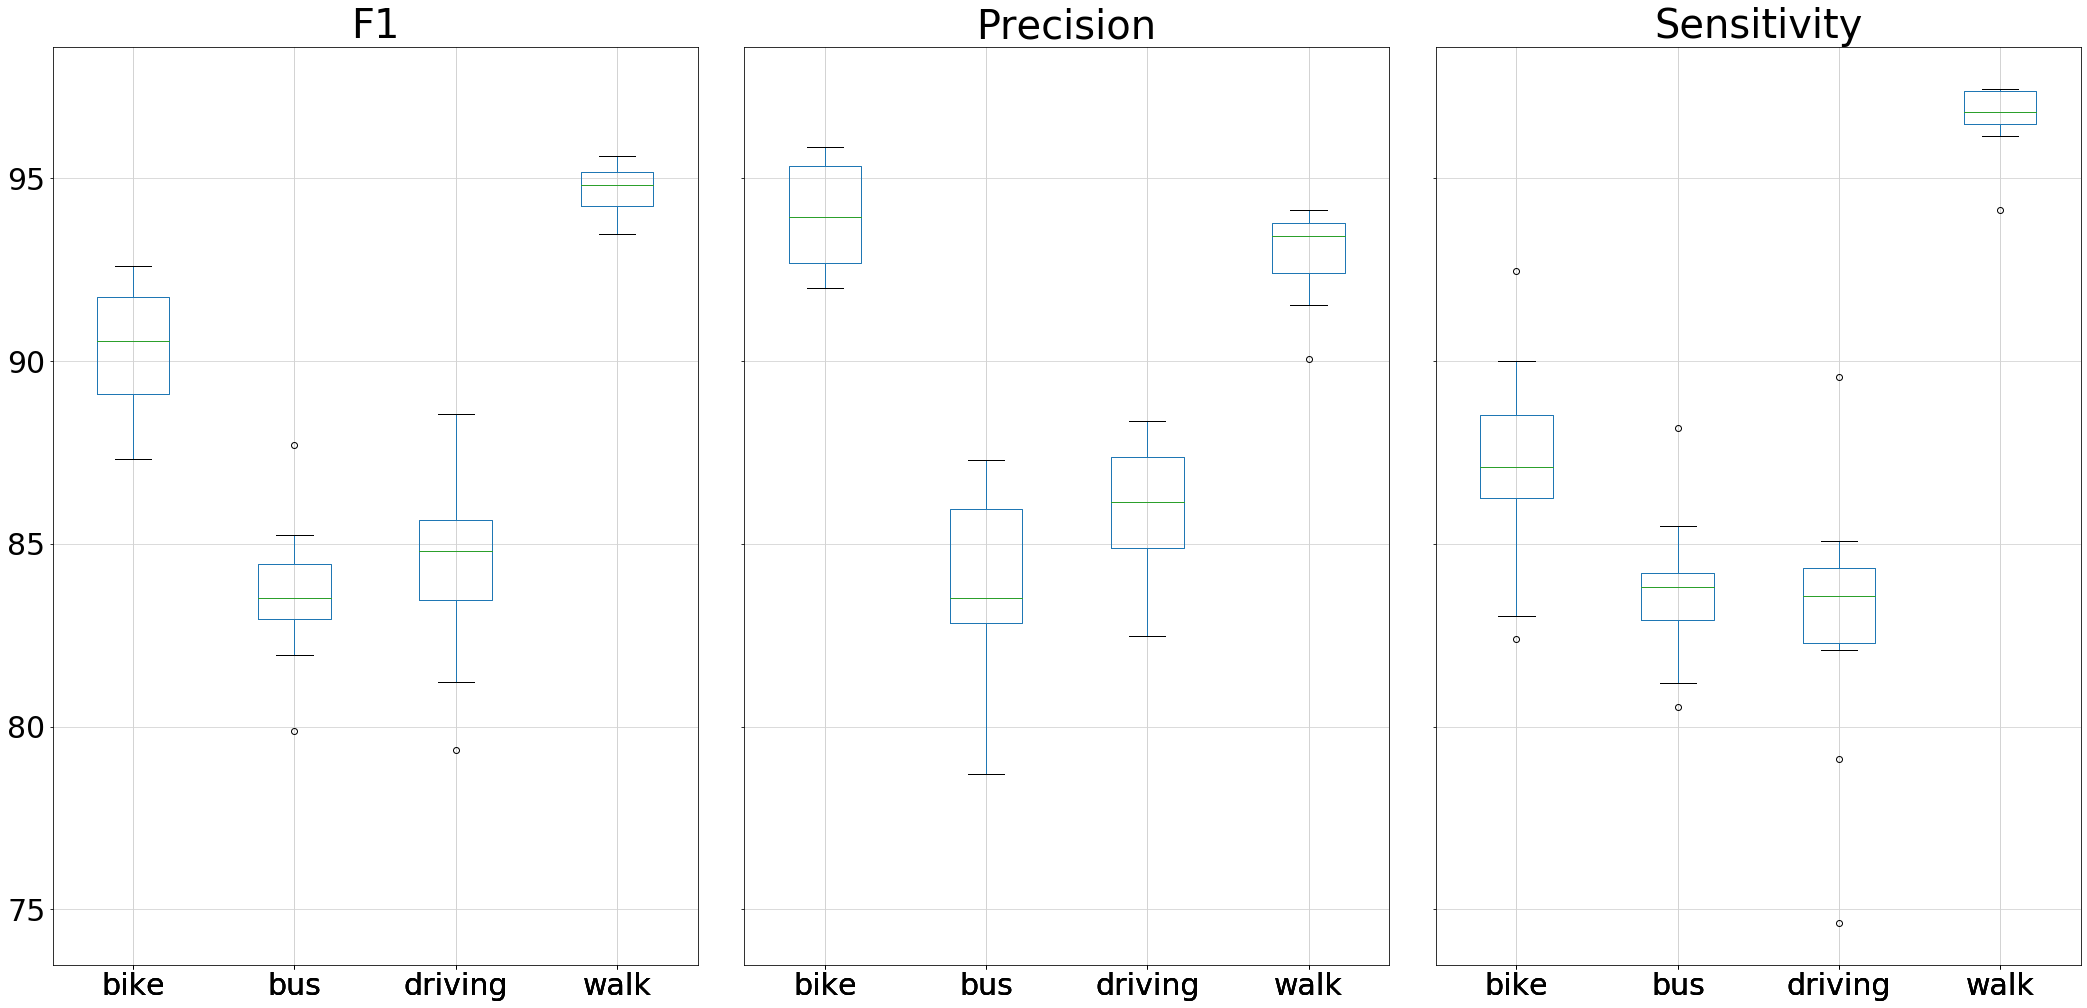

In [117]:
ax = df.boxplot(by = 'Classes', figsize = (30, 15), grid = False, layout = (1, 3), return_type='axes')
plt.suptitle('')
[x.set_xlabel('') for x in ax]

[x.grid(True, color = "lightgray", linestyle='-') for x in ax]

save_title = 'boxplot_metrics'
plt.tight_layout()
plt.savefig('figs/' + save_title + '.pdf')

In [34]:
D       = 4
folder  = clf_paths[66].split("/")[-1]
classes = ["bike", "walk"]

print_values(folder, classes, n_folds, kind, D)

Accuracy: 95.71 (+- 0.46)

--- bike ---
 F1 : 92.3 (+- 0.86)
 REC: 88.95 (+- 2.0)
 PRE: 96.02 (+- 1.5)


--- walk ---
 F1 : 97.03 (+- 0.31)
 REC: 98.47 (+- 0.65)
 PRE: 95.64 (+- 0.74)



In [35]:
D       = 4
folder  = clf_paths[67].split("/")[-1]
classes = ["bus", "walk"]

print_values(folder, classes, n_folds, kind, D)

Accuracy: 96.03 (+- 0.56)

--- bus ---
 F1 : 93.78 (+- 0.84)
 REC: 92.89 (+- 0.85)
 PRE: 94.71 (+- 1.4)


--- walk ---
 F1 : 97.08 (+- 0.42)
 REC: 97.52 (+- 0.71)
 PRE: 96.66 (+- 0.39)



In [36]:
D       = 4
folder  = clf_paths[68].split("/")[-1]
classes = ["driving", "walk"]

print_values(folder, classes, n_folds, kind, D)

Accuracy: 97.56 (+- 0.46)

--- driving ---
 F1 : 95.24 (+- 0.87)
 REC: 95.37 (+- 0.97)
 PRE: 95.13 (+- 1.5)


--- walk ---
 F1 : 98.36 (+- 0.31)
 REC: 98.31 (+- 0.54)
 PRE: 98.41 (+- 0.33)



In [38]:
D       = 4
folder  = clf_paths[69].split("/")[-1]
classes = ["bike", "driving"]

print_values(folder, classes, n_folds, kind, D)

Accuracy: 97.14 (+- 0.75)

--- bike ---
 F1 : 97.36 (+- 0.69)
 REC: 97.3 (+- 0.9)
 PRE: 97.43 (+- 0.76)


--- driving ---
 F1 : 96.87 (+- 0.82)
 REC: 96.94 (+- 0.92)
 PRE: 96.81 (+- 1.1)



In [39]:
D       = 4
folder  = clf_paths[70].split("/")[-1]
classes = ["bus", "driving"]

print_values(folder, classes, n_folds, kind, D)

Accuracy: 88.58 (+- 0.59)

--- bus ---
 F1 : 90.32 (+- 0.54)
 REC: 91.76 (+- 1.2)
 PRE: 88.94 (+- 0.64)


--- driving ---
 F1 : 86.08 (+- 0.68)
 REC: 84.18 (+- 1.1)
 PRE: 88.11 (+- 1.4)



In [40]:
D       = 4
folder  = clf_paths[71].split("/")[-1]
classes = ["bike", "bus"]

print_values(folder, classes, n_folds, kind, D)

Accuracy: 95.3 (+- 0.98)

--- bike ---
 F1 : 94.94 (+- 1.1)
 REC: 95.29 (+- 1.6)
 PRE: 94.64 (+- 1.6)


--- bus ---
 F1 : 95.62 (+- 0.92)
 REC: 95.31 (+- 1.5)
 PRE: 95.97 (+- 1.3)



In [41]:
#### confusion matrix
paths     = join("db", "GeoLife")
clf_paths = get_files(paths, "classification", rec = True)


path    = join(clf_paths[65], "ConfusionMatrices_[4, 1].txt")
cm      = pd.read_csv(path, skiprows = 50, sep = ' ')

cm.columns = ["bike", "bus", "driving", "walk"]
cm.index   = ["bike", "bus", "driving", "walk"]

cm

,bike,bus,driving,walk
bike,1388,46,10,149
bus,43,1554,152,107
driving,8,187,1111,34
walk,38,72,21,3779


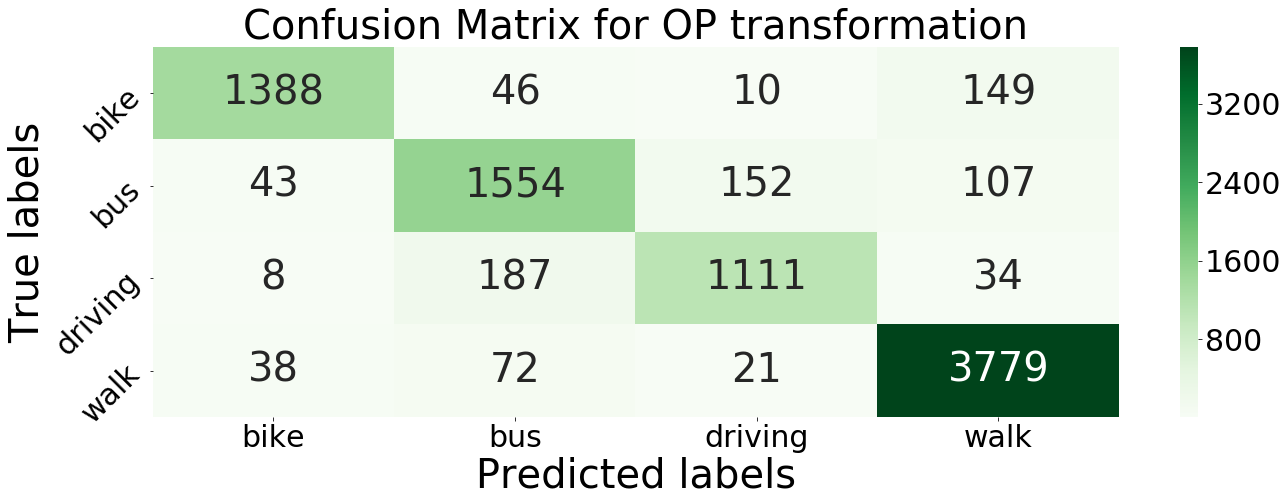

In [42]:
classes = ["bike", "bus", "driving", "walk"]

plt.figure(figsize=(20, 8)) 

ax = plt.subplot()
sns_plot = sns.heatmap(cm, annot = True, ax = ax, cmap = 'Greens', fmt = 'g') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix for OP transformation') 

ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes, rotation = 45)

plt.tight_layout()

fig = sns_plot.get_figure()

save_title = "confusion_matrix"
plt.savefig('figs/' + save_title + '.pdf', dpi = 600)

### Statistics about the dataset

In [25]:
def get_size(folder, tau):
    
    data  = pd.read_csv(join("db", "GeoLife", folder, f"DATASET__op_[4, {tau}].csv"))
    
    size  = len(data)
    
    count = Counter(data["classes"])
    
    
    print(f"For tau = {tau}: n  = {size}")
    
    print(count)
    
    probs = [(x1, x2 / size) for x1, x2 in count.items()]
    
    for c, p in probs:
        print(f"Probs: {c} -- {p}")
        
    print()

In [26]:
folder = "classification_2021-02-17 11:02:18.436427"
taus   = [1, 3, 5, 10, 15]

for tau in taus:
    get_size(folder, tau)

For tau = 1: n  = 8699
Counter({'walk': 3910, 'bus': 1856, 'bike': 1593, 'driving': 1340})
Probs: bus -- 0.2133578572249684
Probs: driving -- 0.15404069433268192
Probs: walk -- 0.4494769513737211
Probs: bike -- 0.18312449706862857

For tau = 3: n  = 8699
Counter({'walk': 3910, 'bus': 1856, 'bike': 1593, 'driving': 1340})
Probs: bus -- 0.2133578572249684
Probs: driving -- 0.15404069433268192
Probs: walk -- 0.4494769513737211
Probs: bike -- 0.18312449706862857

For tau = 5: n  = 8519
Counter({'walk': 3789, 'bus': 1836, 'bike': 1578, 'driving': 1316})
Probs: bus -- 0.2155182533161169
Probs: driving -- 0.15447822514379622
Probs: walk -- 0.444770512971006
Probs: bike -- 0.18523300856908087

For tau = 10: n  = 8099
Counter({'walk': 3515, 'bus': 1807, 'bike': 1526, 'driving': 1251})
Probs: bus -- 0.2231139646869984
Probs: driving -- 0.15446351401407582
Probs: walk -- 0.43400419804914186
Probs: bike -- 0.18841832324978391

For tau = 15: n  = 7676
Counter({'walk': 3222, 'bus': 1774, 'bike': 147

In [27]:
classes         = ['walk', 'bus', 'car', 'bike', 'taxi']
folder_segments = join("db", "GeoLife", "segments")

In [28]:
for transport in classes:
    segment_size = []
    
    print(transport)
    
    query               = transport + "*.csv"
    user_transportation = get_files(folder_segments, query, True)

    for ind in range(len(user_transportation)):

        n = len(pd.read_csv(user_transportation[ind]))
        segment_size.append(n)
    
    print("mean (std): {:.02f} (+- {:.02f})".format(np.mean(segment_size), np.std(segment_size)))
    print("max trajectory size: {}; min trajectory size: {}".format(max(segment_size), min(segment_size)))
    print()

walk
mean (std): 412.86 (+- 1038.21)
max trajectory size: 19836; min trajectory size: 11

bus
mean (std): 691.88 (+- 911.13)
max trajectory size: 19604; min trajectory size: 11

car
mean (std): 627.88 (+- 866.97)
max trajectory size: 8394; min trajectory size: 12

bike
mean (std): 602.23 (+- 972.73)
max trajectory size: 22080; min trajectory size: 11

taxi
mean (std): 470.92 (+- 758.70)
max trajectory size: 10841; min trajectory size: 11



In [29]:
classes  = ['car', 'taxi']

segment_size = []

for transport in classes:
        
    print(transport)
    
    query               = transport + "*.csv"
    user_transportation = get_files(folder_segments, query, True)

    for ind in range(len(user_transportation)):

        n = len(pd.read_csv(user_transportation[ind]))
        segment_size.append(n)

print("mean (std): {:.02f} (+- {:.02f})".format(np.mean(segment_size), np.std(segment_size)))
print("max trajectory size: {}; min trajectory size: {}".format(max(segment_size), min(segment_size)))

car
taxi
mean (std): 567.44 (+- 830.48)
max trajectory size: 10841; min trajectory size: 11


In [30]:
classes  = ['walk', 'bus', 'car', 'bike', 'taxi']

segment_size = []

for transport in classes:
        
    print(transport)
    
    query               = transport + "*.csv"
    user_transportation = get_files(folder_segments, query, True)

    for ind in range(len(user_transportation)):

        n = len(pd.read_csv(user_transportation[ind]))
        segment_size.append(n)

print("mean (std): {:.02f} (+- {:.02f})".format(np.mean(segment_size), np.std(segment_size)))
print("max trajectory size: {}; min trajectory size: {}".format(max(segment_size), min(segment_size)))

walk
bus
car
bike
taxi
mean (std): 530.88 (+- 976.75)
max trajectory size: 22080; min trajectory size: 11
